<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
from pandas import DataFrame
from os import path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
train_dir = "./train_dataset"
test_dir = "./test_dataset"
label_filename = path.join(train_dir, "train_labels.csv")
train_img_dir = path.join(train_dir,"train")
test_img_dir = path.join(test_dir,"test")

In [3]:
labels = pd.read_csv(label_filename, index_col=0)
labels['filename'] = labels.index.astype(str) + ".jpg"
#labels['filename'] = labels.apply(lambda row: path.join(dataset, row.name.astype(str)+".jpg"), axis=1)

In [4]:
labels.head()

,invasive,filename
name,,
1,0,1.jpg
2,0,2.jpg
3,1,3.jpg
4,0,4.jpg
5,1,5.jpg


In [55]:
SEED=42
TARGET_SIZE=(128,128)
BATCHSIZE = 32

In [56]:
labels_train,labels_valid = train_test_split(labels, test_size=0.2, random_state=SEED)

In [57]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.05,
                                   zoom_range=[0.7,0.9],
                                   rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_noaugment = ImageDataGenerator(rescale=1./255)
options = {'directory': train_img_dir,
           'x_col': "filename",
           'y_col': "invasive",
           'batchsize': BATCHSIZE,
           'class_mode': "raw",  
           'target_size': TARGET_SIZE,
           'seed': SEED
          }

train_generator = train_datagen.flow_from_dataframe(dataframe=labels_train, shuffle=True, **options)
valid_generator = train_datagen.flow_from_dataframe(dataframe=labels_valid, shuffle=False, **options)
noaugment_generator = train_datagen_noaugment.flow_from_dataframe(dataframe=labels_train, shuffle=False, **options)

Found 1836 validated image filenames.
Found 459 validated image filenames.
Found 1836 validated image filenames.


In [ ]:
image = next(train_generator)[0]

plt.figure(figsize=(10,8))
for i in range(3):
    for j in range(3):
        idx = 3*i+j
        plt.subplot(3,3,idx+1)
        plt.imshow(image[idx])
plt.show()

In [58]:
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.metrics import AUC

In [59]:
def build_model(size=(64,64)):
    return Sequential([
        Input(shape=(size[0],size[1],3)),
        Conv2D(16,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(32,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64,(3,3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128,(3,3)),
        Activation('relu'),
        GlobalMaxPooling2D(),
        Dropout(rate=0.2),
        Dense(16),
        Activation('relu'),
        Dense(1),
        Activation('sigmoid')
    ])

In [60]:
model = build_model(size=TARGET_SIZE)

In [61]:
loss='binary_crossentropy'
metrics=[AUC()]
LEARNING_RATE = 0.01
EPOCHS = 30

In [62]:
model = build_model(size=TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 126, 126, 16)      448       
_________________________________________________________________
activation_112 (Activation)  (None, 126, 126, 16)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 61, 61, 32)        4640      
_________________________________________________________________
activation_113 (Activation)  (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 28, 28, 64)       

In [63]:
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 15 steps
Epoch 1/30
58/58 [==============================] - 38s 653ms/step - loss: 0.6452 - auc_2: 0.6101 - val_loss: 0.6093 - val_auc_2: 0.8278
Epoch 2/30
58/58 [==============================] - 37s 630ms/step - loss: 0.6050 - auc_2: 0.7388 - val_loss: 0.5645 - val_auc_2: 0.8322
Epoch 3/30
58/58 [==============================] - 37s 646ms/step - loss: 0.5416 - auc_2: 0.8065 - val_loss: 0.4808 - val_auc_2: 0.8807
Epoch 4/30
58/58 [==============================] - 37s 635ms/step - loss: 0.4535 - auc_2: 0.8670 - val_loss: 0.3822 - val_auc_2: 0.9155
Epoch 5/30
58/58 [==============================] - 37s 636ms/step - loss: 0.3764 - auc_2: 0.9072 - val_loss: 0.3130 - val_auc_2: 0.9447
Epoch 6/30
58/58 [==============================] - 36s 624ms/step - loss: 0.3241 - auc_2: 0.9312 - val_loss: 0.2581 - val_auc_2: 0.9580
Epoch 7/30
58/58 [==============================] - 36s 627ms/step - loss: 0.3047 - au

In [64]:
# def plot_history(history):
#     pd.DataFrame(history.history).plot(figsize=(8, 5))#, logy=True)
#     plt.grid(True)
#     #plt.gca().set_ylim(0, 1)
#     plt.title('Model performance throughout training')
#     plt.ylabel('Loss')
#     plt.xlabel('epoch')
#     plt.show()
    
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    fig = plt.figure(figsize=(15,8))
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = fig.add_subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        ax.grid(True)
        ax.set_title(f'Model performance throughout training ({metric})')
        ax.set_xlabel('epoch')
    return fig

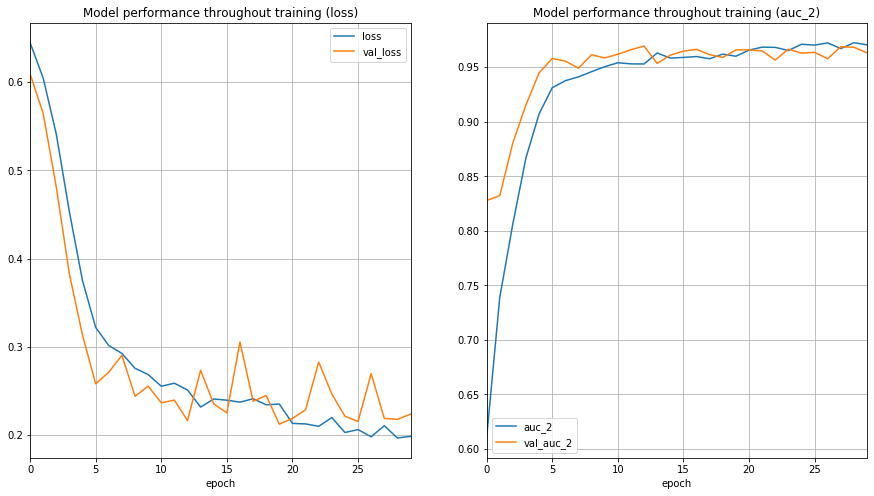

In [70]:
plot_history(history, val=True, metrics=['loss', 'auc']);

In [71]:
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)

In [72]:
y_valid.shape, y_pred_valid.shape

((459,), (459, 1))

In [73]:
from tensorflow import math
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score

In [74]:
def plot_roc_curve(fpr, tpr, thresholds):
    fig = plt.figure(figsize=(14,6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.plot(fpr, thresholds, 'r--', label='threshold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.xlim([-0.02, 1])
    plt.ylim([0, 1.02])

    plt.legend(loc="lower right")
    #return fig

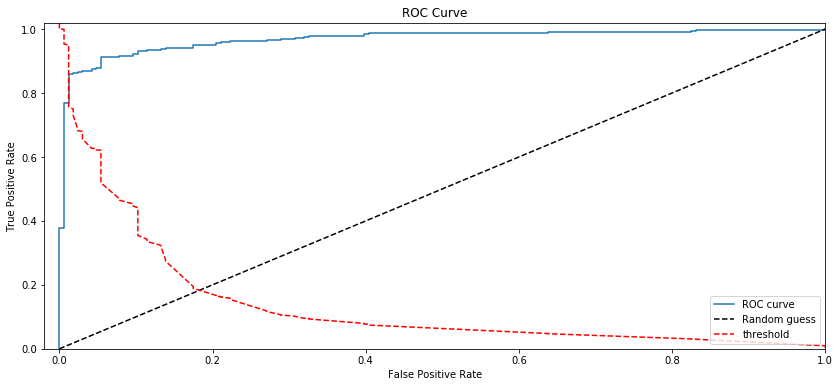

AUC: 0.9676384719766438


In [75]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
plot_roc_curve(fpr, tpr, thresholds)
plt.show()
print(f"AUC: {auc(fpr, tpr)}")

In [76]:
y_pred_train = model.predict_generator(noaugment_generator)

In [77]:
pred_df = pd.DataFrame()
y_train = labels_train['invasive']
pred_df['label'] = labels_train['invasive']
pred_df['pred_proba'] = y_pred_train

#pred_df['label'] = labels_valid['invasive']
#pred_df['pred_proba'] = y_pred_valid

pred_df = pred_df.sort_values(by='pred_proba')

total=pred_df.shape[0]
n_positive = (pred_df['label'] == 1).sum()
n_negative = (pred_df['label'] == 0).sum()

pred_df['FP'] = pred_df['label'].cumsum()
pred_df['TP'] = n_positive - pred_df['FP']
pred_df['TN'] = (1-pred_df['label']).cumsum() 
pred_df['FN'] = n_negative - pred_df['TN']

total=pred_df.shape[0]

pred_df['accuracy'] = (pred_df['TN'] + pred_df['TP'])/total

pred_df = pred_df.reset_index()

idx_max = pred_df['accuracy'].idxmax()
best_thres = (pred_df['pred_proba'][idx_max]+pred_df['pred_proba'][idx_max+1])/2

best_thres = pred_df['accuracy'].sort_values().head(pred_df.shape[0]//100).mean()

print(f"Threshold: {best_thres}")
#print(f"Train Accuracy: {pred_df['accuracy'][idx_max]}")
print(f"Train Accuracy: {accuracy_score(y_train, (y_pred_train >=best_thres).astype(int))}")
print(f"Valid Accuracy: {accuracy_score(y_valid, (y_pred_valid >=best_thres).astype(int))}")

Threshold: 0.37554466230936817
Train Accuracy: 0.8741830065359477
Valid Accuracy: 0.9172113289760349


In [78]:
pred_df.sort_values(by='accuracy', ascending=False).head()

,name,label,pred_proba,FP,TP,TN,FN,accuracy
745,573,0,0.086848,113,1042,633,48,0.912309
747,1883,0,0.088408,114,1041,634,47,0.912309
744,1804,0,0.086706,113,1042,632,49,0.911765
746,1475,1,0.088189,114,1041,633,48,0.911765
748,1673,1,0.088462,115,1040,634,47,0.911765


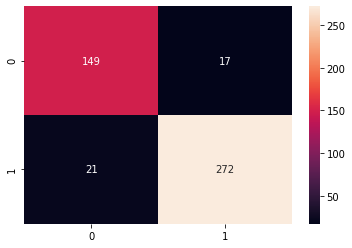

In [79]:
y_pred_valid_class = (y_pred_valid >= best_thres).astype(int)
conf_matrix = math.confusion_matrix(y_valid,y_pred_valid_class>0.7)
sns.heatmap(data=conf_matrix, annot=True, fmt="d")
plt.show()

In [ ]:
TARGET_SIZE=(128,128)

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [22]:
def build_VGG16(size=(64,64)):
    model = VGG16(weights= 'imagenet', include_top=False, input_shape=(size[0],size[1],3))
    
    for layer in model.layers:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(128)(output)
    output = Activation('relu')(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    
    model = Model(model.input, output)
    return model

In [23]:
model = build_VGG16(TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [24]:
EPOCHS = 20
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 15 steps
Epoch 1/20
58/58 [==============================] - 116s 2s/step - loss: 0.6472 - auc: 0.7249 - val_loss: 0.3717 - val_auc: 0.9198
Epoch 2/20
58/58 [==============================] - 117s 2s/step - loss: 0.4224 - auc: 0.8782 - val_loss: 0.3475 - val_auc: 0.9358
Epoch 3/20
58/58 [==============================] - 116s 2s/step - loss: 0.3796 - auc: 0.9034 - val_loss: 0.3039 - val_auc: 0.9407
Epoch 4/20
58/58 [==============================] - 117s 2s/step - loss: 0.3581 - auc: 0.9131 - val_loss: 0.2841 - val_auc: 0.9459
Epoch 5/20
58/58 [==============================] - 116s 2s/step - loss: 0.3410 - auc: 0.9222 - val_loss: 0.2934 - val_auc: 0.9419
Epoch 6/20
58/58 [==============================] - 120s 2s/step - loss: 0.3495 - auc: 0.9171 - val_loss: 0.2918 - val_auc: 0.9397
Epoch 7/20
58/58 [==============================] - 121s 2s/step - loss: 0.3252 - auc: 0.9290 - val_loss: 0.3059 - val_auc

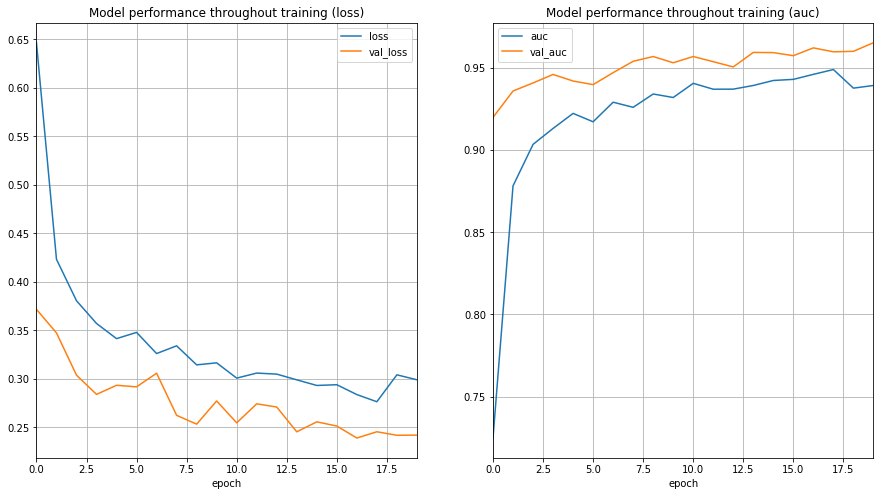

In [28]:
plot_history(history, metrics=['loss', 'auc'], val=True);

In [29]:
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)

AUC: 0.9584686870348287


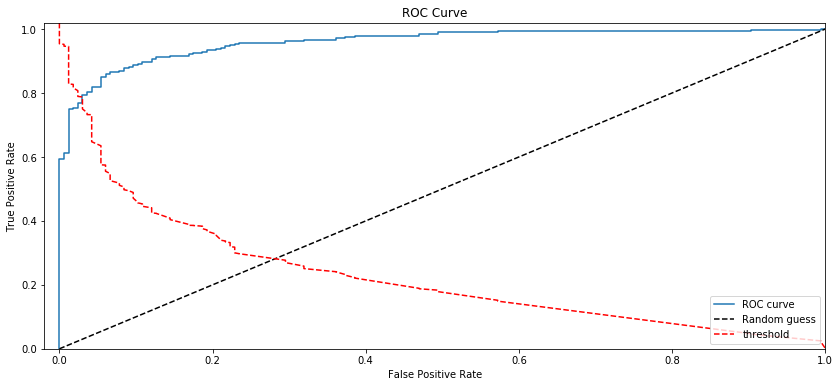

In [30]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
plot_roc_curve(fpr, tpr, thresholds)
print(f"AUC: {auc(fpr, tpr)}")

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [32]:
def build_InceptionV3(size=(128,128)):
    model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(size[0],size[1],3))
    
    for layer in model.layers:
        layer.trainable = False
        
    output = model.output
    output = Flatten()(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(128)(output)
    output = Activation('relu')(output)
    output = Dropout(rate=0.5)(output)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    
    model = Model(model.input, output)
    return model

In [33]:
model = build_InceptionV3(TARGET_SIZE)
model.compile(loss=loss, optimizer='adamax', metrics=metrics)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 63, 63, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [34]:
EPOCHS = 10
history = model.fit_generator(train_generator, epochs=EPOCHS, validation_data=valid_generator, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 15 steps
Epoch 1/10
58/58 [==============================] - 62s 1s/step - loss: 0.6598 - auc: 0.6852 - val_loss: 0.6019 - val_auc: 0.7984
Epoch 2/10
58/58 [==============================] - 66s 1s/step - loss: 0.5420 - auc: 0.7833 - val_loss: 0.6342 - val_auc: 0.8679
Epoch 3/10
58/58 [==============================] - 64s 1s/step - loss: 0.5244 - auc: 0.8038 - val_loss: 0.9610 - val_auc: 0.8500
Epoch 4/10
58/58 [==============================] - 58s 997ms/step - loss: 0.5129 - auc: 0.8174 - val_loss: 0.6287 - val_auc: 0.8427
Epoch 5/10
58/58 [==============================] - 57s 982ms/step - loss: 0.4704 - auc: 0.8445 - val_loss: 0.6857 - val_auc: 0.8447
Epoch 6/10
58/58 [==============================] - 58s 1s/step - loss: 0.4874 - auc: 0.8319 - val_loss: 0.6696 - val_auc: 0.8629
Epoch 7/10
58/58 [==============================] - 61s 1s/step - loss: 0.4485 - auc: 0.8591 - val_loss: 0.5733 - val_auc:

AUC: 0.8687651630412435


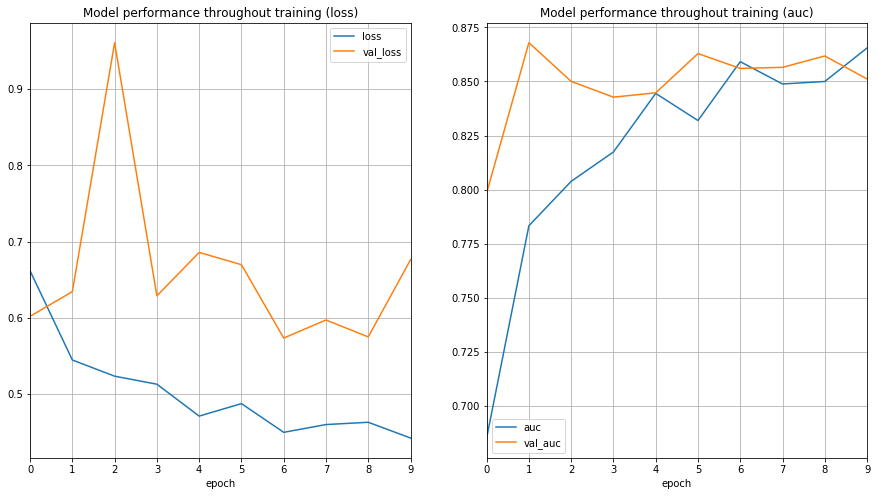

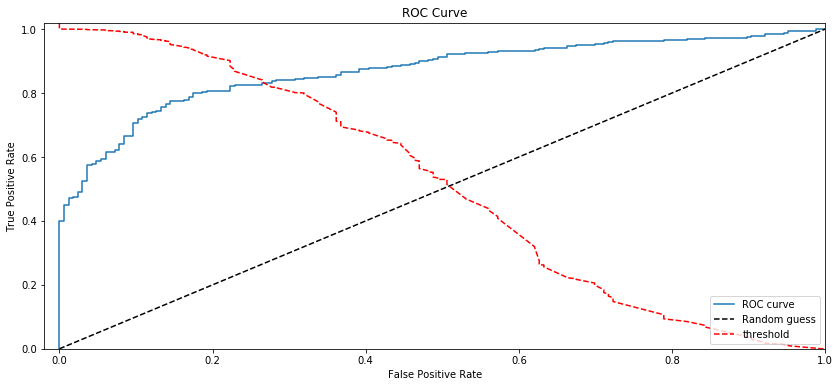

In [36]:
plot_history(history, metrics=['loss', 'auc'], val=True);
y_valid = labels_valid['invasive']
y_pred_valid = model.predict_generator(valid_generator)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_valid)
plot_roc_curve(fpr, tpr, thresholds);
print(f"AUC: {auc(fpr, tpr)}")